## 5. Linear ensemble filtering Lorenz-96 problem with localization

In this notebook, we apply the stochastic ensemble Kalman filter to the Lorenz-96 problem.

To regularize the inference problem, we use a localization radius `L` to cut-off long-range correlations and improve the conditioning of the covariance matrix. We refers readers to Asch et al. [2] for further details.

[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

[6] Evensen, G. (2003). The ensemble Kalman filter: Theoretical formulation and practical implementation. Ocean dynamics, 53(4), 343-367.

[7] Tsitouras, C. (2011). Runge–Kutta pairs of order 5 (4) satisfying only the first column simplifying assumption. Computers & Mathematics with Applications, 62(2), 770-775.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions

Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

The Lorenz-96 model  is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing... The forty-dimensional state $\boldsymbol{x} = (x_1, \ldots, x_{40})$ at time $t$ is governed by the following set of ordinary differential equations: 
\begin{equation}
\label{eqn:lorenz96}
\frac{\mathrm{d} x_i}{\mathrm{d} t} = (x_{i+1} - x_{i-2}) x_{i-1} - x_{i} + F, \quad \mbox{for } i = 1, \ldots, 40,
\end{equation}
with periodic boundary conditions, setting the forcing input $F=8.0$ leads to chaos. We reproduce the hard configuration case of Spantini et al. [5]. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. We observe the state with $\Delta t_{obs}=0.4$, every two components ($x_1, x_3, x_5, \ldots, x_{39})$. The large time interval between two assimilation makes the problem particularly challenging and enhances the non-Gaussianity. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. We assume that there is no process noise. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_{20}$ where $\theta^2 = 0.5$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 40
Ny = 20

20

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [65]:
Δtdyn = 0.01
Δtobs = 0.4

0.4

Define the time span of interest

In [66]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

250

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [67]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 40
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching [7]. 

We assume that the state is observed every two components.

In [68]:
h(x, t) = x[1:2:end]
h(x, idx, t) = x[idx]

F = StateSpace(lorenz96!, h)

StateSpace(AdaptiveTransportMap.lorenz96!, h)

`ϵx` defines the additive process noise applied between the forecast step and the analysis step. The process noise is applied before to sample form the likelihood.

`ϵy` defines the additive observation noise. 

We assume that these noises have Gaussian distribution.

In [69]:
σx = 1e-6
σy = 0.5

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.25 0.0 … 0.0 0.0; 0.0 0.25 … 0.0 0.0; … ; 0.0 0.0 … 0.25 0.0; 0.0 0.0 … 0.0 0.25], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5])

In [70]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [71]:
x0 = rand(model.π0);

Run dynamics and generate data

In [72]:
@time data = generate_lorenz96(model, x0, Tf);

  0.010997 seconds (24.95 k allocations: 3.955 MiB)


Define a stochastic ensemble Kalman filter without localization

In [73]:
senkf = StochEnKF(model.ϵy, model.Δtdyn, model.Δtobs)

Stochastic EnKF  with filtered = false


Define a stochastic ensemble Kalman filter with localization

In [117]:
Δ = 2
yidx = 1:Δ:model.Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')
β = 1.0
Lrad = 6

senkfloc = SeqStochEnKF(x->x, F.h, MultiplicativeInflation(β), model.ϵy, Ny, Nx, model.Δtdyn, model.Δtobs, 
                    idx, zeros(Nx+1, Ne), false, true)

# Create Localization structure
Gxy(i,j) = periodicmetric!(i,yidx[j], model.Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], model.Nx)
Loc = Localization(Lrad, Gxy, Gyy)

Localization(6.0, Gxy, Gyy)

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [118]:
Ne = 100 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne);

Apply the sequential filter over the time window

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

Without localization

In [119]:
@time Xsenkf = seqassim(F, data, Tf, model.ϵx, senkf, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.317979 seconds (1.95 M allocations: 413.333 MiB, 7.89% gc time)


RMSE without localization

In [120]:
mean(map(i->norm(data.xt[:,i]-mean(Xsenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

1.8000447741999013

`mean_hist` stacked together the ensemble mean over the assimilation window.

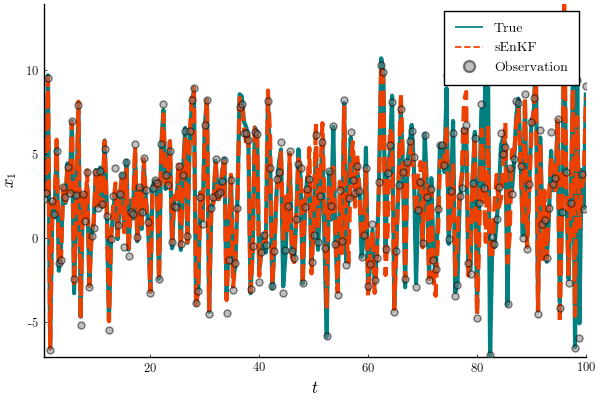

In [121]:
# Plot the first component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsenkf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

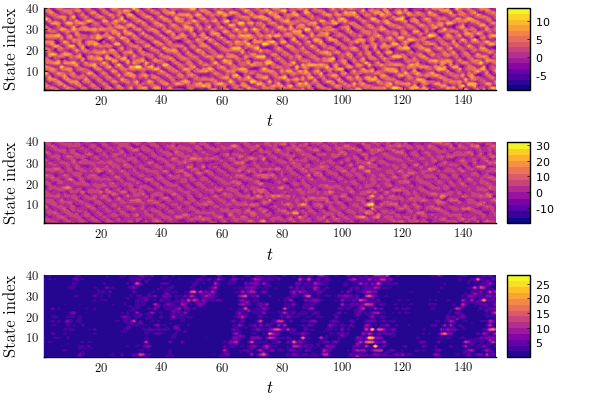

In [122]:
nb = 100
ne = size(Xsenkf,1)-1
Δ = 1

plt = plot(layout = grid(3,1), xlabel = L"t", ylabel = "State index")
contourf!(plt[1,1], data.xt[:,nb:Δ:ne], color = :plasma)
contourf!(plt[2,1], mean_hist(Xsenkf)[:,1+nb:Δ:1+ne], color = :plasma)
contourf!(plt[3,1], abs.(mean_hist(Xsenkf)[:,1+nb:Δ:1+ne] .- data.xt[:,nb:Δ:ne]), color = :plasma)

Localization can easily be added as a regularization of the analysis step as follows

In [123]:
@time Xsenkfloc = seqassim(F, data, Tf, model.ϵx, senkfloc, deepcopy(X), model.Ny, model.Nx, t0, Loc);

  2.285167 seconds (22.64 M allocations: 2.476 GiB, 11.17% gc time)


RMSE with localization

In [124]:
mean(map(i->norm(data.xt[:,i]-mean(Xsenkfloc[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.7022495716187316

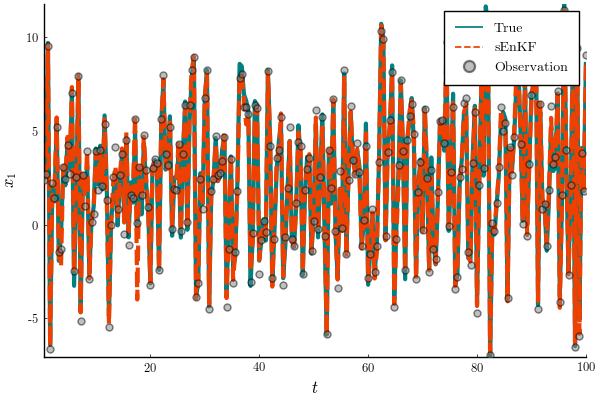

In [125]:
# Plot the first component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsenkfloc)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

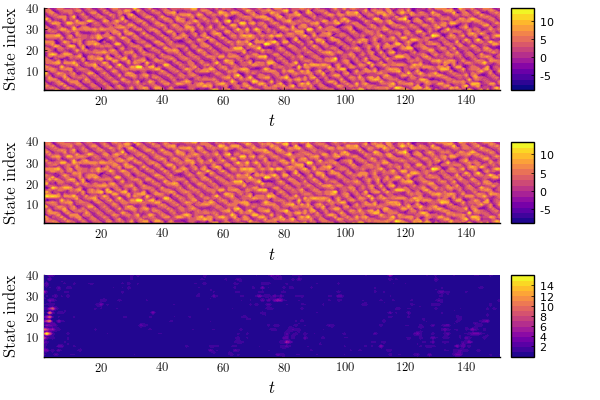

In [126]:
nb = 100
ne = size(Xsenkfloc,1)-1
Δ = 1

plt = plot(layout = grid(3,1), xlabel = L"t", ylabel = "State index")
contourf!(plt[1,1], data.xt[:,nb:Δ:ne], color = :plasma)
contourf!(plt[2,1], mean_hist(Xsenkfloc)[:,1+nb:Δ:1+ne], color = :plasma)
contourf!(plt[3,1], abs.(mean_hist(Xsenkfloc)[:,1+nb:Δ:1+ne] .- data.xt[:,nb:Δ:ne]), color = :plasma)